In [5]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import cv2

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [6]:
width = 128
height = 128

# 주어진 폴더의 모든 파일을 numpy array로 변환하는 함수
def convertArray(path):
    file_list = os.listdir(path)
    img_X = [] # data
    img_Y = [] # target
    
    for i in range(len(file_list)):
        spt = os.path.splitext(file_list[i])
        # print(spt) # ('0', '.jpg')
        img_Y.append(int(spt[0])) # 파일명
        
#         img = Image.open(path + "/" + file_list[i])
#         img_array = np.array(img)
        image_bgr = cv2.imread(path + "/" + file_list[i], cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # 1차원 list안에 3차원 배열로 변경된 이미지를 저장     
        img_X.append(image_rgb) 

    img_X = np.array(img_X) # 이미지 데이터 [] -> ndarray
    img_Y = np.array(img_Y) # Target, Y

    
    # OpenCV는 흰색을 255로 나타냄으로 변환이 필요함.
    img_X = 255 - img_X # 색이 없으면 0으로 인식되게 변환, 255 - 4차원 배열
    
    # 텐서플로와 GPU 미분 기반에 최적화되어 있어
    # 0 ~ 1 사이의 실수 값으로 변경하면 정확도 상승, 정규화
    img_X = img_X / 255.0
    print('img_X: ', img_X.shape);
    
    # img_Y.reshape(img_Y.shape[0], 1): target은 2차원 배열의 형태이어야함.
    # 행수는 이미지 수, 컬럼이 1개인 2차원 배열
    # astype(int): 찾아야하는 값은 정수이기 때문에 형변환
    return img_X, img_Y.reshape(img_Y.shape[0], 1).astype(int)

In [7]:
# 데이터 준비
x_train, y_train = convertArray('./train') # 훈련용
x_val, y_val = convertArray('./val')       # 검증용
x_test, y_test = convertArray('./test')    # 테스트용 
# (70, 128, 128, 3): 칼라 이미지 70장, (count, width, height, color channel)

img_X:  (70, 128, 128, 3)
img_X:  (18, 128, 128, 3)
img_X:  (5, 128, 128, 3)


In [8]:
print(x_train.shape) 
print(y_train.shape) # (67, 1), 녹초 수치, 정수형

print(x_val.shape)   # 검증데이터
print(y_val.shape)   

print(x_test.shape)  # 테스트 데이터
print(y_test.shape) 
print(y_test)

(70, 128, 128, 3)
(70, 1)
(18, 128, 128, 3)
(18, 1)
(5, 128, 128, 3)
(5, 1)
[[100]
 [150]
 [200]
 [ 47]
 [ 50]]


In [9]:
print(type(x_train[0, 0, 0, 0])) # 첫번째 이미지 첫번째 픽셀의 type 확인
print(x_train[0:1]) # 첫번째 이미지 배열 값

<class 'numpy.float64'>
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


In [10]:
print(y_train[0:10]) # 훈련 target 확인

[[  0]
 [  1]
 [105]
 [108]
 [ 11]
 [115]
 [117]
 [120]
 [125]
 [127]]


In [17]:
width=128
height=128

tf.random.set_seed(0)
model = Sequential()
# 128: 128 개의 2차원 특징맵이 생성됨, 필터(커널)의 수.
# kernel_size = (3, 3): 필터 크기는 3행 3열의 난수기반 행렬이 생성됨.
# padding='same': 차원 축소를 방지, 외곽에 0을 추가 
# input_shape = (width, height, 3): 칼라 입력 이미지, 흑백: 1
# model.add(Conv2D(64, kernel_size = (3, 3), padding='same',
#                  input_shape = (width, height, 3), activation='relu'))

model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
# (None, 128, 128, 128)     3584: 128 x 128 이미지, 128 channel
# 3584: 필터_size * 필터 갯수 * color 수 + Bias 수
#       9 * 128 * 3 + 128  

# 특성맵이 128 -> 32개로 감소
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# 4개중에 최대값 1개만 다음 레이어로 전달, 특징만 추출
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음, 파라미터 감소.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(1)) # 활성화 함수 생략시 수치 예측(회귀 산출)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      36896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [18]:
# mcp = ModelCheckpoint(filepath='./Iris.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                 shuffle=True, epochs=1000, 
                 batch_size=1, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# patience=20
# i5 2320: 313초 i5 8500 6core: 160 초
# gtx 1060: 30 초, Colab: 21.40 초

Epoch 1/1000
70/70 [==============================] - 8s 113ms/step - loss: 9944.8857 - val_loss: 39.0984
Epoch 2/1000
70/70 [==============================] - 8s 121ms/step - loss: 101.3359 - val_loss: 287.5643
Epoch 3/1000
70/70 [==============================] - 8s 114ms/step - loss: 432.1190 - val_loss: 63.9688
Epoch 4/1000
70/70 [==============================] - 8s 117ms/step - loss: 10.2101 - val_loss: 6.1447
Epoch 5/1000
70/70 [==============================] - 8s 116ms/step - loss: 3.7156 - val_loss: 21.2037
Epoch 6/1000
70/70 [==============================] - 7s 103ms/step - loss: 7.1513 - val_loss: 7.7574
Epoch 7/1000
70/70 [==============================] - 7s 104ms/step - loss: 4.5899 - val_loss: 8.0458
Epoch 8/1000
70/70 [==============================] - 8s 114ms/step - loss: 3.5969 - val_loss: 114.4032
Epoch 9/1000
70/70 [==============================] - 7s 106ms/step - loss: 382.1545 - val_loss: 26.5178
Runtime: 70.98 초


### Local에서는 너무 느려서 검증과 테스트를 진행하지 않음

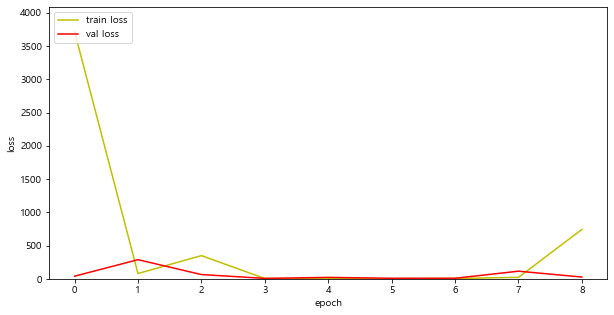

In [19]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 4087.1168]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
# acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
# acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()